In [2]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd

#!conda install -c conda-forge geocoder
import json # library to handle JSON files
from geopy import geocoders
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Get neighborhood data for NewYork and Toronto

In [4]:
# New York Data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('New York Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_ny_data = newyork_data['features']
neighborhoods_ny_data[0]

New York Data downloaded!


{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_ny = pd.DataFrame(columns=column_names)

for data in neighborhoods_ny_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods_ny.head() 

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
print('New York has {} boroughs and {} neighborhoods.'.format(len(neighborhoods_ny['Borough'].unique()),neighborhoods_ny.shape[0]))

New York has 5 boroughs and 306 neighborhoods.


In [7]:
#Toronto Data
#Use BeautifulSoup retrive neibourghood data from the web
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')
table = soup.find('table')


In [8]:
neighborhoods_to=[]
head = [items.text.strip() for items in table.find_all('th')]

for rows in table.find_all('tr'):
    cols = [items.text.strip() for items in rows.find_all('td')]
    neighborhoods_to.append(cols)
    
neighborhoods_to[0]=head
# create the dataframe with retrived data and clean data
neighborhoods_to=pd.DataFrame(neighborhoods_to[1:], columns=neighborhoods_to[0])

# remove rows with a borough that is Not assigned.
neighborhoods_to=neighborhoods_to[neighborhoods_to['Borough']!='Not assigned']

# Combine rows with same Postcode and Borough
neighborhoods_to = neighborhoods_to.groupby(['Postcode','Borough'])['Neighbourhood'].apply(lambda x: ','.join(x)).reset_index()

# If a cell has a borough but a Not assigned neighborhood, replace with the borough
neighborhoods_to['Neighbourhood'] = np.where(neighborhoods_to['Neighbourhood'] == 'Not assigned', 
                                             neighborhoods_to['Borough'], 
                                             neighborhoods_to['Neighbourhood'])

neighborhoods_to.head(2)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"


In [9]:
# Latitude, Longitudedata
location = pd.read_csv('http://cocl.us/Geospatial_data')
location.rename(columns={'Postal Code': "Postcode"}, inplace=True)
location.head(2)

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497


In [10]:
neighborhoods_to = neighborhoods_to.merge(location, how='left', on ='Postcode')
neighborhoods_to.drop(['Postcode'], axis=1, inplace=True)
neighborhoods_to.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
neighborhoods_to.head()

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
print('New York has {} boroughs and {} neighborhoods.'.format(len(neighborhoods_ny['Borough'].unique()), neighborhoods_ny.shape[0]))
print('Toronto has {} boroughs and {} neighborhoods.'.format(len(neighborhoods_to['Borough'].unique()), neighborhoods_to.shape[0]))

New York has 5 boroughs and 306 neighborhoods.
Toronto has 11 boroughs and 103 neighborhoods.


In [12]:
# settings and function to retrive data from Foursquare
CLIENT_ID = '4EGBIM5Y5ENSBXZ11VSSLSJUFD3KWSYKAJ30KAC0XO3BZEAT' # Foursquare ID
CLIENT_SECRET = 'NHI5XOICEHGV0LAVHIXMJIQMG0HVZYGNZKYVZPIYM2G1JBEP' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print("########\n", results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Category ID']
    
    return(nearby_venues)

In [13]:
test = getNearbyVenues(names=neighborhoods_to['Neighborhood'][1:3], latitudes=neighborhoods_to['Latitude'][1:3],longitudes=neighborhoods_to['Longitude'][1:3])
#print('test data shape ', test.shape)
#test.head()

## Retrieve data from foursqure for the neibourhood with only boroughs that contain the word Toronto
Analysis will only focus on boroughs that contain the word Toronto 

In [14]:
##### retrieve infor for Toronto from foursqure #####
#toronto_venues = getNearbyVenues(names=neighborhoods_to['Neighborhood'], latitudes=neighborhoods_to['Latitude'],longitudes=neighborhoods_to['Longitude'])
print('toronto_venues data shape', toronto_venues.shape)
toronto_venues.head(5)

toronto_venues data shape (2243, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,4bf58dd8d48988d16e941735
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,4bf58dd8d48988d116941735
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,4bf58dd8d48988d1ca941735
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store,4bf58dd8d48988d122951735
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa,4bf58dd8d48988d1ed941735


In [15]:
##### retrieve infor for New York from foursqure #####
#ny_venues = getNearbyVenues(names=neighborhoods_ny['Neighborhood'], latitudes=neighborhoods_ny['Latitude'],longitudes=neighborhoods_ny['Longitude'])
print('ny_venues data shape', ny_venues.shape)
ny_venues.head(5)

ny_venues data shape (10347, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,4bf58dd8d48988d1d0941735
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,4bf58dd8d48988d10f951735
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,4bf58dd8d48988d1c9941735
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant,4bf58dd8d48988d144941735
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,4bf58dd8d48988d148941735


In [16]:
print('There are {} uniques venue categorie, {} neighborboods in Toronto'.format(len(toronto_venues['Venue Category'].unique()), 
                                                                           len(toronto_venues['Neighborhood'].unique())))
print('There are {} uniques venue categorie, {} neighborboods in New York'.format(len(ny_venues['Venue Category'].unique()), 
                                                                           len(ny_venues['Neighborhood'].unique())))
#toronto_venues['Venue Category'].unique()

There are 274 uniques venue categorie, 100 neighborboods in Toronto
There are 433 uniques venue categorie, 300 neighborboods in New York


### Save neighborhood and venues data to CSV
### Retrieve main category mapping 

In [17]:
# Save neighborhood and venues data to CSV
#neighborhoods_ny.to_csv("neighborhoods_ny.csv")
#neighborhoods_to.to_csv("neighborhoods_to.csv")
#toronto_venues.to_csv("toronto_venues.csv")
#ny_venues.to_csv("ny_venues.csv")
#mapping.to_csv('mapping.csv')

In [18]:
# Read neighborhood and venues data from CSV
neighborhoods_ny = pd.read_csv("neighborhoods_ny.csv", index_col=0)
neighborhoods_to = pd.read_csv("neighborhoods_to.csv", index_col=0)
toronto_venues = pd.read_csv("toronto_venues.csv", index_col=0)
ny_venues = pd.read_csv("ny_venues.csv", index_col=0)
mapping = pd.read_csv('mapping.csv', index_col=0)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [88]:
mapping.MainCat.unique()

array(['Arts & Entertainment', 'College & Education', 'Event', 'Food',
       'Nightlife', 'Outdoors & Recreation', 'Professional', 'Residence',
       'Shops', 'Travel'], dtype=object)

In [19]:
# Calssify with Main Category
# Toronto data
toronto_venues_maincat = toronto_venues.merge(mapping,how='left', on='Category ID')
toronto_venues_maincat['MainCat']=np.where(toronto_venues_maincat['MainCat'].isnull(),toronto_venues_maincat['Venue Category_x'],toronto_venues_maincat['MainCat'] )
toronto_venues_maincat.drop(columns=['Venue Latitude', 'Venue Longitude', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category_x', 'Venue Category_y', 'Venue', 'Category ID'], inplace=True)
toronto_venues_maincat.reset_index()

# New york data
ny_venues_maincat = ny_venues.merge(mapping,how='left', on='Category ID')
ny_venues_maincat['MainCat']=np.where(ny_venues_maincat['MainCat'].isnull(),ny_venues_maincat['Venue Category_x'],ny_venues_maincat['MainCat'] )
ny_venues_maincat['MainCat']=np.where(ny_venues_maincat['MainCat']=='Shop & Service','Shops',ny_venues_maincat['MainCat'] )
ny_venues_maincat['MainCat']=np.where(ny_venues_maincat['MainCat']=='Nightlife Spot','Nightlife',ny_venues_maincat['MainCat'] )
ny_venues_maincat.drop(columns=['Venue Latitude', 'Venue Longitude', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category_x', 'Venue Category_y', 'Venue', 'Category ID'], inplace=True)
ny_venues_maincat.reset_index()

#ny_venues_maincat['MainCat'].value_counts()
#toronto_venues_maincat['MainCat'].value_counts()
#ny_venues_maincat[ny_venues_maincat['MainCat'].isnull()]
#toronto_venues_maincat[toronto_venues_maincat['MainCat'].isnull()]

ny_venues_maincat.head()

,Neighborhood,MainCat
0,Wakefield,Food
1,Wakefield,Shops
2,Wakefield,Food
3,Wakefield,Food
4,Wakefield,Food


## <font color='red'> Analysis with Main Category </font>

In [89]:
# set dummy value for each category
to_MainCat = pd.get_dummies(toronto_venues_maincat[['MainCat']], prefix="", prefix_sep="")
to_MainCat.insert(0, 'Neighborhood', toronto_venues_maincat['Neighborhood'])

ny_MainCat = pd.get_dummies(ny_venues_maincat[['MainCat']], prefix="", prefix_sep="")
ny_MainCat.insert(0, 'Neighborhood', ny_venues_maincat['Neighborhood'])
ny_MainCat.head(5)

,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Residence,Shops,Travel
0,Wakefield,0,0,1,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,1,0
2,Wakefield,0,0,1,0,0,0,0,0,0
3,Wakefield,0,0,1,0,0,0,0,0,0
4,Wakefield,0,0,1,0,0,0,0,0,0


In [21]:
# Group by Neighborhood, calculate total number of venues in the category for each neighnorhood
## Drop feature 'Residence', as the related data is neglectable

to_MainCat_grouped=to_MainCat.groupby('Neighborhood').sum().reset_index()
#to_MainCat_grouped.head(2)
to_MainCat_grouped.drop(columns=['Residence'], axis=1, inplace =True)

ny_MainCat_grouped = ny_MainCat.groupby('Neighborhood').sum().reset_index()
ny_MainCat_grouped.drop(columns=['Residence'], axis=1, inplace =True)

ny_MainCat_grouped.head()

,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel
0,Allerton,0,0,18,0,1,0,12,2
1,Annadale,0,0,5,1,0,0,3,1
2,Arden Heights,0,0,3,0,0,0,2,0
3,Arlington,0,0,3,0,0,0,1,1
4,Arrochar,0,0,10,0,2,0,4,3


In [90]:
to_MainCat_grouped.head()

,Neighborhood,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel,Cluster Labels
0,"Adelaide,King,Richmond",8,0,64,6,6,1,11,4,4
1,Agincourt,0,0,2,1,1,0,0,0,0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0,0,1,0,2,0,0,0,0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0,0,5,0,0,0,4,0,3
4,"Alderwood,Long Branch",0,0,4,1,4,0,1,0,0


In [22]:
to_MainCat_Feature = to_MainCat_grouped.iloc[:, 1:]

ny_MainCat_Feature = ny_MainCat_grouped.iloc[:, 1:]

to_MainCat_Feature.head()

,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel
0,8,0,64,6,6,1,11,4
1,0,0,2,1,1,0,0,0
2,0,0,1,0,2,0,0,0
3,0,0,5,0,0,0,4,0
4,0,0,4,1,4,0,1,0


In [23]:
# KNN for clustering, used original data (groupby sum) instead of standard scaled data
from sklearn.preprocessing import StandardScaler

def clustering(feature, num_clusters):
    
    X = feature
    
    #cluster_dataset = StandardScaler().fit_transform(X)
    cluster_dataset=X

    k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=20)
    k_means.fit(cluster_dataset)

    return k_means.labels_



#### Run k-means to cluster the neighborhood into 5 clusters.

In [24]:
k=5

labels_to=clustering(to_MainCat_Feature, k)
to_MainCat_grouped['Cluster Labels']=labels_to
to_MainCat_grouped['Cluster Labels'].value_counts()
#to_MainCat_grouped.head()

0    55
3    22
2    12
4     6
1     5
Name: Cluster Labels, dtype: int64

In [25]:
labels_ny=clustering(ny_MainCat_Feature, k)
ny_MainCat_grouped["Cluster Labels"]=labels_ny
ny_MainCat_grouped['Cluster Labels'].value_counts()
#ny_MainCat_grouped.head()

0    105
4     90
2     45
3     31
1     29
Name: Cluster Labels, dtype: int64

In [26]:
toronto_merged=to_MainCat_grouped[['Neighborhood', 'Cluster Labels']].copy()
toronto_merged=toronto_merged.merge(neighborhoods_to, how='left', on='Neighborhood')

ny_merged=ny_MainCat_grouped[['Neighborhood', 'Cluster Labels']].copy()
ny_merged=ny_merged.merge(neighborhoods_ny, how='left', on='Neighborhood')
#len(ny_merged['Neighborhood'].unique())
ny_merged.head()

,Neighborhood,Cluster Labels,Borough,Latitude,Longitude
0,Allerton,2,Bronx,40.865788,-73.859319
1,Annadale,0,Staten Island,40.538114,-74.178549
2,Arden Heights,0,Staten Island,40.549286,-74.185887
3,Arlington,0,Staten Island,40.635325,-74.165104
4,Arrochar,4,Staten Island,40.596313,-74.067124


In [27]:
# get Latitude and Longitude of the city
def get_LL( address):
    geolocator = Nominatim(user_agent="ny_explorer")
    address= address
    location= geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    return latitude, longitude


In [28]:
location_ny = get_LL('Manhattan, NY, USA')
location_to = get_LL('Toronto, ON, Canada')

latitude_ny = location_ny[0]
longitude_ny = location_ny[1]
latitude_to = location_to[0]
longitude_to = location_to[1]
print("location of NY is: ",latitude_ny, longitude_ny )
print("location of Toronto is: ",latitude_to, longitude_to )

location of NY is:  40.7900869 -73.9598295
location of Toronto is:  43.653963 -79.387207


In [86]:
# create map

map_clusters = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):

    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    

map_clusters

In [47]:
# create map

map_clusters = folium.Map(location=[latitude_to, longitude_to], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):

    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
        
map_clusters

In [31]:
# use groupby mean(). For each cluster, caculate: average number of venues in each category per neighborhood

to_MainCat_Cluster=to_MainCat_grouped.groupby('Cluster Labels').mean().transpose()

for i in range(k):
    print('Top 3 venues for type {} cluser in Toronto: \n{}\n'.format(i, to_MainCat_Cluster[i].sort_values(ascending=False)[0:3]))

to_MainCat_Cluster


Top 3 venues for type 0 cluser in Toronto: 
Food                     1.490909
Outdoors & Recreation    1.090909
Shops                    1.000000
Name: 0, dtype: float64

Top 3 venues for type 1 cluser in Toronto: 
Food         53.2
Shops        16.8
Nightlife     8.8
Name: 1, dtype: float64

Top 3 venues for type 2 cluser in Toronto: 
Food         26.500000
Shops         9.166667
Nightlife     3.666667
Name: 2, dtype: float64

Top 3 venues for type 3 cluser in Toronto: 
Food                     9.045455
Shops                    5.545455
Outdoors & Recreation    1.500000
Name: 3, dtype: float64

Top 3 venues for type 4 cluser in Toronto: 
Food         68.500000
Shops         8.333333
Nightlife     7.833333
Name: 4, dtype: float64



Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.090909,7.0,1.750000,0.363636,4.166667
College & Education,0.018182,0.2,0.333333,0.000000,0.000000
Food,1.490909,53.2,26.500000,9.045455,68.500000
Nightlife,0.145455,8.8,3.666667,0.818182,7.833333
Outdoors & Recreation,1.090909,5.8,2.583333,1.500000,3.833333
Professional,0.036364,1.0,0.166667,0.090909,1.000000
Shops,1.000000,16.8,9.166667,5.545455,8.333333
Travel,0.581818,3.8,0.500000,0.363636,4.333333


In [32]:
# use groupby mean(). For each cluster, caculate: average number of venues in each category per neighborhood

ny_MainCat_Cluster=ny_MainCat_grouped.groupby('Cluster Labels').mean().transpose()

for i in range(k):
    print('Top 3 venues for type {} cluser in New York: \n{}\n'.format(i, ny_MainCat_Cluster[i].sort_values(ascending=False)[0:3]))

ny_MainCat_Cluster

Top 3 venues for type 0 cluser in New York: 
Food                     3.638095
Shops                    1.895238
Outdoors & Recreation    1.723810
Name: 0, dtype: float64

Top 3 venues for type 1 cluser in New York: 
Food                     40.172414
Shops                    17.413793
Outdoors & Recreation    10.448276
Name: 1, dtype: float64

Top 3 venues for type 2 cluser in New York: 
Food                     23.511111
Shops                    11.111111
Outdoors & Recreation     3.111111
Name: 2, dtype: float64

Top 3 venues for type 3 cluser in New York: 
Food         55.709677
Shops        21.741935
Nightlife     9.451613
Name: 3, dtype: float64

Top 3 venues for type 4 cluser in New York: 
Food                     12.033333
Shops                     6.166667
Outdoors & Recreation     1.644444
Name: 4, dtype: float64



Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.333333,5.448276,1.066667,2.741935,0.388889
College & Education,0.000000,0.068966,0.022222,0.096774,0.033333
Food,3.638095,40.172414,23.511111,55.709677,12.033333
Nightlife,0.295238,5.793103,1.800000,9.451613,0.733333
Outdoors & Recreation,1.723810,10.448276,3.111111,7.322581,1.644444
Professional,0.104762,0.758621,0.222222,0.870968,0.100000
Shops,1.895238,17.413793,11.111111,21.741935,6.166667
Travel,1.200000,2.413793,1.022222,1.677419,1.211111


In [33]:
'''
correlation calculated by relative category importance, 
i.e weight of the category for each cluster in each category (number of venues/sum(category total for all clusters))
'''
ny_MainCat_Cluster_scaled=ny_MainCat_Cluster/ny_MainCat_Cluster.sum(axis=1).values.reshape(8,-1)
#from sklearn import preprocessing
#Min_Max_ny = preprocessing.MinMaxScaler()

ny_MainCat_Cluster_scaled

Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.033403,0.545969,0.106890,0.274768,0.038970
College & Education,0.000000,0.311645,0.100419,0.437308,0.150628
Food,0.026936,0.297431,0.174073,0.412467,0.089093
Nightlife,0.016336,0.320534,0.099594,0.522960,0.040576
Outdoors & Recreation,0.071084,0.430853,0.128292,0.301959,0.067812
Professional,0.050940,0.368876,0.108055,0.423505,0.048625
Shops,0.032492,0.298546,0.190491,0.372748,0.105723
Travel,0.159478,0.320789,0.135852,0.222926,0.160955


In [34]:
ny_MainCat_Cluster_scaled.corr()

Cluster Labels,0,1,2,3,4
Cluster Labels,,,,,
0,1.000000,0.013470,0.116131,-0.744936,0.388064
1,0.013470,1.000000,-0.411633,-0.474702,-0.550057
2,0.116131,-0.411633,1.000000,-0.180539,0.271055
3,-0.744936,-0.474702,-0.180539,1.000000,-0.293758
4,0.388064,-0.550057,0.271055,-0.293758,1.000000


In [35]:
'''
correlation calculated by relative category importance, 
i.e weight of the category for each cluster in each category (number of venues/sum(category total for all clusters))
'''
to_MainCat_Cluster_scaled=to_MainCat_Cluster/to_MainCat_Cluster.sum(axis=1).values.reshape(8,-1)
to_MainCat_Cluster_scaled

Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.006799,0.523513,0.130878,0.027195,0.311615
College & Education,0.032967,0.362637,0.604396,0.000000,0.000000
Food,0.009392,0.335147,0.166943,0.056984,0.431533
Nightlife,0.006841,0.413852,0.172438,0.038478,0.368391
Outdoors & Recreation,0.073672,0.391691,0.174460,0.101299,0.258876
Professional,0.015852,0.435931,0.072655,0.039630,0.435931
Shops,0.024483,0.411306,0.224423,0.135767,0.204021
Travel,0.060740,0.396710,0.052199,0.037963,0.452388


In [36]:
to_MainCat_Cluster_scaled.corr()

Cluster Labels,0,1,2,3,4
Cluster Labels,,,,,
0,1.000000,-0.290777,0.004175,0.268190,-0.141711
1,-0.290777,1.000000,-0.375882,-0.098555,0.135739
2,0.004175,-0.375882,1.000000,-0.278178,-0.913703
3,0.268190,-0.098555,-0.278178,1.000000,0.021160
4,-0.141711,0.135739,-0.913703,0.021160,1.000000


In [37]:
'''
correlation between NY and Toronto calculated by relative category importance, 
i.e weight of the category for each cluster in each category (number of venues/sum(category total for all clusters))
'''
corr = np.zeros((k,k))
#filt = [0,1,3,4,5,6,7,8]

for i in range(k):
    for j in range(k):
        corr[i,j] = np.corrcoef(ny_MainCat_Cluster_scaled.iloc[:,i], to_MainCat_Cluster_scaled.iloc[:,j])[0,1]

In [99]:
corr

TO,0,1,2,3,4
NY,,,,,
0,0.659760,0.011891,-0.577827,0.092849,0.511683
1,-0.008705,0.803229,-0.265294,-0.118272,0.041230
2,0.053134,-0.379861,-0.179012,0.746460,0.119919
3,-0.581879,-0.310630,0.376531,-0.157867,-0.169718
4,0.490063,-0.552161,0.432400,-0.098121,-0.340572


In [39]:
corr = pd.DataFrame(corr)
corr.index.name = 'NY'
corr.columns.name = 'TO'

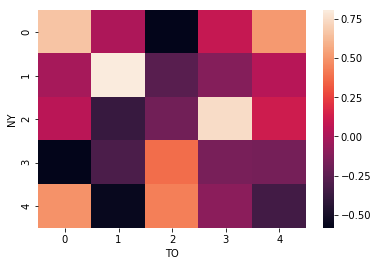

In [40]:
import seaborn as sns
%matplotlib inline
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#### from above heatmap, mapping from NY to Toronto: NY[0, 1, 2, 3, 4] to TO[[0, 1], 3, [0,2], 2, 4 ]

In [41]:
'''
Average number of venues in each category per neighborhood, with average total number of venues per nerghborhood in the cluster
correlation between NY and Toronto
'''
to_MainCat_Cluster_withTotal = to_MainCat_Cluster.copy()
ny_MainCat_Cluster_withTotal = ny_MainCat_Cluster.copy()
to_MainCat_Cluster_withTotal.loc['Total_venues'] = to_MainCat_Cluster_withTotal.sum()
ny_MainCat_Cluster_withTotal.loc['Total_venues'] = ny_MainCat_Cluster_withTotal.sum()

ny_MainCat_Cluster_withTotal

Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.333333,5.448276,1.066667,2.741935,0.388889
College & Education,0.000000,0.068966,0.022222,0.096774,0.033333
Food,3.638095,40.172414,23.511111,55.709677,12.033333
Nightlife,0.295238,5.793103,1.800000,9.451613,0.733333
Outdoors & Recreation,1.723810,10.448276,3.111111,7.322581,1.644444
Professional,0.104762,0.758621,0.222222,0.870968,0.100000
Shops,1.895238,17.413793,11.111111,21.741935,6.166667
Travel,1.200000,2.413793,1.022222,1.677419,1.211111
Total_venues,9.190476,82.517241,41.866667,99.612903,22.311111


In [42]:
to_MainCat_Cluster_withTotal

Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.090909,7.0,1.750000,0.363636,4.166667
College & Education,0.018182,0.2,0.333333,0.000000,0.000000
Food,1.490909,53.2,26.500000,9.045455,68.500000
Nightlife,0.145455,8.8,3.666667,0.818182,7.833333
Outdoors & Recreation,1.090909,5.8,2.583333,1.500000,3.833333
Professional,0.036364,1.0,0.166667,0.090909,1.000000
Shops,1.000000,16.8,9.166667,5.545455,8.333333
Travel,0.581818,3.8,0.500000,0.363636,4.333333
Total_venues,4.454545,96.6,44.666667,17.727273,98.000000


In [43]:
corr_withTotal = np.zeros((k,k))
#filt = [0,1,3,4,5,6,7,8]

for i in range(k):
    for j in range(k):
        corr_withTotal[i,j] = np.corrcoef(ny_MainCat_Cluster_withTotal.iloc[:,i], to_MainCat_Cluster_withTotal.iloc[:,j])[0,1]
        

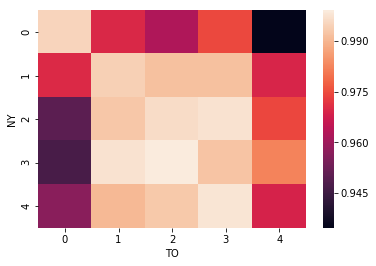

In [44]:
corr_withTotal = pd.DataFrame(corr_withTotal)
corr_withTotal.index.name = 'NY'
corr_withTotal.columns.name = 'TO'
sns.heatmap(corr_withTotal, 
        xticklabels=corr_withTotal.columns,
        yticklabels=corr_withTotal.columns)

In [91]:
# with customized weight
MainCat=list(to_MainCat_Cluster_withTotal.index)
MainCat_score=[]
print('please input your customized weight/score for each category below: the most not important: 1 to the most important:10 \n', MainCat)
for i in range(len(MainCat)):
    MainCat_score.append(int(input(MainCat[i])))
MainCat_score = np.array(MainCat_score).transpose().reshape(9,-1)
customized=pd.DataFrame(MainCat_score, columns=['Customized Score'], index=MainCat)

print("\nYour customized score as below: \n\n", customized)


please input your customized weight/score for each category below: the most not important: 1 to the most important:10 
 ['Arts & Entertainment', 'College & Education', 'Food', 'Nightlife', 'Outdoors & Recreation', 'Professional', 'Shops', 'Travel', 'Total_venues']


Arts & Entertainment 1
College & Education 1
Food 8
Nightlife 1
Outdoors & Recreation 10
Professional 2
Shops 3
Travel 5
Total_venues 5



Your customized score as below: 

                        Customized Score
Arts & Entertainment                  1
College & Education                   1
Food                                  8
Nightlife                             1
Outdoors & Recreation                10
Professional                          2
Shops                                 3
Travel                                5
Total_venues                          5


In [97]:
to_MainCat_Cluster_customized=to_MainCat_Cluster_withTotal * MainCat_score
ny_MainCat_Cluster_customized=ny_MainCat_Cluster_withTotal * MainCat_score

#to_MainCat_Cluster_customized=to_MainCat_Cluster_withTotal * MainCat_customized_weight
#ny_MainCat_Cluster_customized=ny_MainCat_Cluster_withTotal * MainCat_customized_weight
to_MainCat_Cluster_customized

Cluster Labels,0,1,2,3,4
Arts & Entertainment,0.090909,7.0,1.750000,0.363636,4.166667
College & Education,0.018182,0.2,0.333333,0.000000,0.000000
Food,11.927273,425.6,212.000000,72.363636,548.000000
Nightlife,0.145455,8.8,3.666667,0.818182,7.833333
Outdoors & Recreation,10.909091,58.0,25.833333,15.000000,38.333333
Professional,0.072727,2.0,0.333333,0.181818,2.000000
Shops,3.000000,50.4,27.500000,16.636364,25.000000
Travel,2.909091,19.0,2.500000,1.818182,21.666667
Total_venues,22.272727,483.0,223.333333,88.636364,490.000000


In [93]:
diff = np.array(to_MainCat_Cluster_withTotal.max(axis=1)- to_MainCat_Cluster_withTotal.min(axis=1)).reshape(9, -1)

MainCat_customized_weight = MainCat_score/(np.array(to_MainCat_Cluster_withTotal.max(axis=1)).reshape(9, -1))
MainCat_customized_weight
#MainCat_score[-1]=1
#MainCat_score

array([[0.14285714],
       [3.        ],
       [0.11678832],
       [0.11363636],
       [1.72413793],
       [2.        ],
       [0.17857143],
       [1.15384615],
       [0.05102041]])

In [94]:
to_MainCat_Cluster_withTotal.max(axis=1)

Arts & Entertainment      7.000000
College & Education       0.333333
Food                     68.500000
Nightlife                 8.800000
Outdoors & Recreation     5.800000
Professional              1.000000
Shops                    16.800000
Travel                    4.333333
Total_venues             98.000000
dtype: float64

In [73]:
#to_MainCat_Cluster_withTotal.max(axis=1)

In [95]:
corr_customized = np.zeros((k,k))

for i in range(k):
    for j in range(k):
        corr_customized[i,j] = np.corrcoef(ny_MainCat_Cluster_customized.iloc[:,i], to_MainCat_Cluster_customized.iloc[:,j])[0,1]
corr_customized  

array([[0.9884953 , 0.94803941, 0.93599804, 0.9618325 , 0.90252323],
       [0.94393169, 0.98966087, 0.98524755, 0.99490011, 0.96314314],
       [0.89454905, 0.99844446, 0.99856946, 0.99775373, 0.98576944],
       [0.89481414, 0.99922207, 0.99899839, 0.99687825, 0.98722848],
       [0.90213465, 0.99814062, 0.99678062, 0.99850003, 0.98209215]])

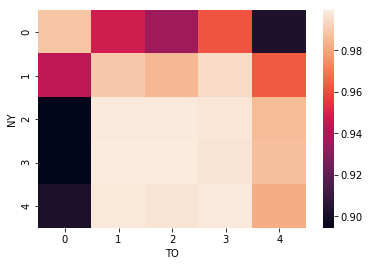

In [96]:
corr_customized = pd.DataFrame(corr_customized)
corr_customized.index.name = 'NY'
corr_customized.columns.name = 'TO'
sns.heatmap(corr_customized, 
        xticklabels=corr_customized.columns,
        yticklabels=corr_customized.columns)